In [2]:
from itertools import chain
from collections import defaultdict, Counter
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#  Approximating theoretical maximum accuracy

We know, that $RSSI = 11 \lg \frac{P}{P_0}$

So, knowing, that intensity is the power transfered per unit area, and by having power in numenator and denominator, we can conclude, that $RSSI = 10 \lg \frac{\mathcal{I}}{\mathcal{I}_0}$  

Due to Inverse-square law we know, that $\mathcal{I} \propto \frac{1}{r^2}$:

So, $\mathcal{I} = \frac{c}{r^2}$

$RSSI = 10 \lg \mathcal{I} - 10 \lg \mathcal{I_0} = 
10 \lg{\frac{c}{r^2}} - 10 \lg{\mathcal{I_0}} =
-20 \lg{r} + 10 \lg{c} - 10 \lg{\mathcal{I_0}}$

Let's substitute $\mathcal{C} = 10 \lg{c} - 10 \lg{\mathcal{I_0}}$, as
it don't depends on distance and is constant


$RSSI = -20 \lg r + \mathcal{C}$  

So let's find the range of distance, that can correspond to same value of RSSI.  
We will use next charachteristics of kit (CY8CPROTO-063-BLE), that we are using:
 - Resolution in 1 db
 - Accuracy in 4 db

So we will create sequence of distance [0.01 - 10] m, 
and then finding corresponding RSSI. After that we will create groups with rssi values, that are in
range [c-accuracy, c+accuracy]. So this group will map to the distance interval and we will
assume, that we cannot distinguish rssi's on this interval. 

##  1-dimensional case

In [3]:
@np.vectorize

def rssi_from_distance(d):
    return -20*np.log10(d)


def get_bins_according_to_accuracy(rssi, accuracy):
    bins = np.arange(rssi.min(), rssi.max())
    group_size = int(accuracy*2 + 1)

    

    split_indeces = list(range(group_size, bins.shape[0], group_size))
    if split_indeces[-1] != bins.shape[0] - 1:
        split_indeces.append(bins.shape[0]-1)

        

    bins = np.split(bins, split_indeces)
    bins=np.fromiter(map(np.mean, bins), dtype=float)

    return [ bins[abs(bins - rssi[i]).argmin()] for i in range(rssi.shape[0])]


def get_intervals_with_same_rssi(rssi_bins, dist_bins):
    rssi_to_dist_map = defaultdict(list)
    for rssi, dist in zip(rssi_bins, dist_bins):
        rssi_to_dist_map[rssi].append(dist)
    return np.array([(min(distances), max(distances)) for distances in rssi_to_dist_map.values()])

def get_radiuses_for_distance_contour_lines(intervals):
    radiuses = np.array([end for st, end in intervals])
    return radiuses

Distance steps: [0.01 0.02 0.05 0.16 0.47 1.33 3.75 9.99]


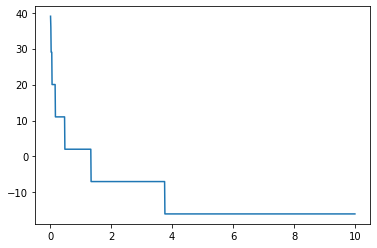

In [4]:
distances = np.arange(0.01, 10, 0.01)
rssi = rssi_from_distance(distances)

rssi_bins = get_bins_according_to_accuracy(rssi, 4)

sns.lineplot(x=distances, y=rssi_bins)

intervals = get_intervals_with_same_rssi(rssi_bins, distances)
radiuses = get_radiuses_for_distance_contour_lines(intervals)

print("Distance steps:", radiuses)

##  2-dimensional case

###  Define local enviroment constants

In [5]:
x_len = 3
y_len = 4

beacon_number = 3
beacons_location = np.array([[0.5, 0.5], [2.5, 3.5], [1, 1]])

###  Generate Grid of points

In [6]:
def cartesian_cross_product(x,y):
    cross_product = np.transpose([np.tile(x, len(y)),np.repeat(y,len(x))])
    return cross_product

delta = 0.01
points = cartesian_cross_product(np.arange(0, x_len, delta), np.arange(0, y_len, delta))

###  Group points by the same RSSI regions

In [7]:
def distance(p1, p2):
    def helper(p1, p2):
        return (((p1[:,0] - p2[0])**2 + (p1[:,1] - p2[1])**2)**0.5)
    vectorized_distance = np.vectorize(helper, signature='(n,m),(m)->(n)')
    
    return np.apply_along_axis(lambda x: vectorized_distance(p1, x), 1, p2)

distance = np.vectorize(distance, signature='(n,m),(k,m)->(k,n)')

@np.vectorize
def find_interval_num(dist):
    return (dist > radiuses).argmin() - 1

def find_point_flag(p, beacons_location, radiuses):
    return find_interval_num(distance(p, beacons_location).T)

find_point_flag = np.vectorize(find_point_flag, signature='(n,m),(i,m),(j)->(n,i)')

In [8]:
point_flags = find_point_flag(points, beacons_location, radiuses)

points_grouped_list = defaultdict(list)
for i in range(point_flags.shape[0]):
     points_grouped_list[tuple(point_flags[i])].append(points[i])

points_grouped = dict()
for group in points_grouped_list.keys():
    points_grouped[group] = np.array(points_grouped_list[group])

###  Get rid of small regions

In [9]:
minimum_radius = 0.1

min_group = np.asscalar(find_interval_num(minimum_radius))

points_grouped_without_small = dict(filter(lambda x: any(map(lambda x: x >= min_group, x[0])), points_grouped.items()))

###  Calculate accuracy

In [10]:
def accuracy_by_box(points):
    x_boundary = np.array([min(points, key=lambda x: x[0])[0], max(points, key=lambda x: x[0])[0]])
    y_boundary = np.array([min(points, key=lambda x: x[1])[1], max(points, key=lambda x: x[1])[1]])

    minima, maxima = np.concatenate([x_boundary.reshape(1, -1), y_boundary.reshape(1, -1)]).T
    return np.asscalar(distance(minima.reshape(1,-1), maxima.reshape(1,-1)))/2

def accuracy_by_mean_dist(points):
    return np.mean(distance(points, points))

In [11]:
region_accuracy_by_box = dict()

for region in points_grouped_without_small.items():
    region_accuracy_by_box[region[0]] = accuracy_by_box(region[1])

In [12]:
region_accuracy_by_mean_dist = dict()

for region in points_grouped_without_small.items():
    region_accuracy_by_mean_dist[region[0]] = accuracy_by_mean_dist(region[1])

In [13]:
accuracies = np.array([np.fromiter(chain(region_accuracy_by_box.values()), float),

                       np.fromiter(chain(region_accuracy_by_mean_dist.values()), float)])

Text(0.5, 0, 'Number of Group')

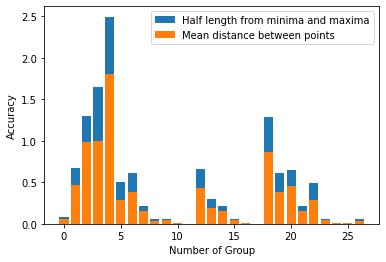

In [14]:
cont = plt.bar(x=range(accuracies.shape[1]), height=accuracies[0,:])
cont = plt.bar(x=range(accuracies.shape[1]), height=accuracies[1,:])

plt.legend(["Half length from minima and maxima", "Mean distance between points"])
plt.ylabel("Accuracy")
plt.xlabel("Number of Group")

In [15]:
print("Mean accuracy using half length of minima and maxima: {:.2}".format(np.mean(accuracies[0])))
print("Mean accuracy using mean distance between points: {:.2}".format(np.mean(accuracies[1])))

Mean accuracy using half length of minima and maxima: 0.46
Mean accuracy using mean distance between points: 0.31
